In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

if os.getcwd() == '/content':
    data_path = '/content/drive/MyDrive/Colab Notebooks/datasets'
else:
    data_path = r'G:\내 드라이브\Colab Notebooks\datasets'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# hyper-params
num_epochs = 4
batch_size = 4
learning_rate = 0.001

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root=data_path, train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=data_path, train=False,
                                download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(train_dataset), len(train_loader)

(50000, 12500)

In [7]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

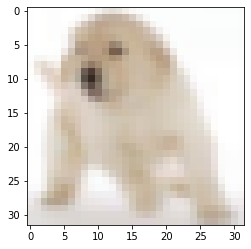

In [8]:
plt.imshow((images[0] / 2 + 0.5).permute(1, 2, 0))

In [9]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5) # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [11]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # (4, 3, 32, 32)
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print(f'[epoch {epoch+1}/{num_epochs}, step {i+1:5d}/{n_total_steps}] loss : {loss.item():.4f}')

print('Finished Training')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # (value, index)
        _, predicted = torch.max(outputs, dim=1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy : {acc} %')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]} class accuracy : {acc} %')

[epoch 1/4, step  2000/12500] loss : 2.3372
[epoch 1/4, step  4000/12500] loss : 2.2868
[epoch 1/4, step  6000/12500] loss : 2.2780
[epoch 1/4, step  8000/12500] loss : 2.1625
[epoch 1/4, step 10000/12500] loss : 1.9080
[epoch 1/4, step 12000/12500] loss : 1.8119
[epoch 2/4, step  2000/12500] loss : 1.7885
[epoch 2/4, step  4000/12500] loss : 1.6569
[epoch 2/4, step  6000/12500] loss : 1.5228
[epoch 2/4, step  8000/12500] loss : 1.6156
[epoch 2/4, step 10000/12500] loss : 1.7721
[epoch 2/4, step 12000/12500] loss : 2.0175
[epoch 3/4, step  2000/12500] loss : 2.6697
[epoch 3/4, step  4000/12500] loss : 1.0789
[epoch 3/4, step  6000/12500] loss : 2.0203
[epoch 3/4, step  8000/12500] loss : 1.3712
[epoch 3/4, step 10000/12500] loss : 0.7426
[epoch 3/4, step 12000/12500] loss : 0.6421
[epoch 4/4, step  2000/12500] loss : 1.5415
[epoch 4/4, step  4000/12500] loss : 1.3669
[epoch 4/4, step  6000/12500] loss : 1.1951
[epoch 4/4, step  8000/12500] loss : 1.3287
[epoch 4/4, step 10000/12500] lo